# Outlier Detection Prototype
This notebook demonstrates how to detect and impute outliers in TimeSeriesDataFrame. The method used is adapted from [this StackExchange article](https://stats.stackexchange.com/questions/1142/simple-algorithm-for-online-outlier-detection-of-a-generic-time-series).

In [1]:
import warnings
warnings.filterwarnings("ignore") 

import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.nonparametric.smoothers_lowess import lowess
from ftk.data import load_dow_jones_dataset

print('Imports done')

Imports done


/home/jma/.conda/envs/py35/lib/python3.5/site-packages/ftk/pipeline.py:33: UserWarning: Unable to import TimeSeriesLogger. Logging/Telemetry will be disabled.
  UserWarning)


In [2]:
import matplotlib
matplotlib.use('agg')
%matplotlib inline
import matplotlib.pyplot as plt

def plot_by_grain(tsdf):
    # Convert a tsdf back to a wide pandas df, and plot the individual grains
    x = pd.DataFrame(tsdf)
    y = x.reset_index(level=['company_ticker', 'quarter_start'] )#level=["company_ticker"])
    z = y.pivot(index='quarter_start', columns='company_ticker')
    z.plot()

In [3]:
# Helper function to detect outlier for a single time series
def _remove_outlier_single_grain(ts, iqr_limit=1.5,
                                 residual_compute_method='stl',
                                 replace_with='nan',
                                 output_outlier_score=False):
    if not ts.time_index.is_monotonic:
        ts.sort_index(level=ts.time_colname, inplace=True)
    ts_values = ts[ts.ts_value_colname].values
    if residual_compute_method == 'stl':
        # Get residual from stl decomposition
        if ts.grain_colnames:
            # seasonal_decompose doesn't handle multi index, need to 
            # drop grain index
            ts_tmp = ts.reset_index(ts.grain_colnames, drop=True)
        else:
            ts_tmp = ts
        stl = seasonal_decompose(ts_tmp[ts_tmp.ts_value_colname])
        residual = stl.resid.values
    elif residual_compute_method == 'lowess':
        # Get residual from lowess smoother
        x = np.array(range(1, len(ts_values) + 1))
        ts_smoothed = lowess(endog=ts_values, exog=x,
                             is_sorted=True, missing='none',
                             return_sorted=False)
        residual = ts_values - ts_smoothed

    residual_non_nan = residual[~np.isnan(residual)]
    quantile_25 = np.percentile(residual_non_nan, 25)
    quantile_75 = np.percentile(residual_non_nan, 75)
    iqr = quantile_75 - quantile_25

    limits = (quantile_25 - iqr_limit * iqr, quantile_75 + iqr_limit * iqr)

    lower_limit_score = (residual - limits[0]) / iqr
    # With stl decomposition, we get nan outlier scores at the beginning and
    #  end of the time series, because the residuals are nans.
    lower_limit_score[np.isnan(lower_limit_score)] = 0
    lower_limit_score[lower_limit_score > 0] = 0

    upper_limit_score = (residual - limits[1]) / iqr
    # With stl decomposition, we get nan outlier scores at the beginning and
    #  end of the time series, because the residuals are nans.
    upper_limit_score[np.isnan(upper_limit_score)] = 0
    upper_limit_score[upper_limit_score < 0] = 0

    outlier_score = abs(lower_limit_score) + upper_limit_score

    if replace_with == 'nan':
        np.place(ts_values, outlier_score > 0, np.nan)
    elif replace_with == 'iqr_bound':
        # NOTE: the 'iqr_bound' option is currently implemented in a suboptimal way. 
        # the quantiles are computed from the raw data, while the outliers are
        # identified from the residuals. Ideally, if the residuals are computed by
        # 'stl', the replacement values should be computed by (trend + seasonality 
        # +/- iqr_limit * iqr). If the residuals are computed by 'lowess', the 
        # replacement values should be computed by (ts_smoothed +/- iqr_limit * iqr).
        # Please fix this when adopting this function to an actual class. 
        ts_values_non_nan = ts_values[~np.isnan(ts_values)]
        ts_quantile_25 = np.percentile(ts_values_non_nan, 25)
        ts_quantile_75 = np.percentile(ts_values_non_nan, 75)
        np.place(ts_values, lower_limit_score < 0, ts_quantile_25)
        np.place(ts_values, upper_limit_score > 0, ts_quantile_75)

    if replace_with:
        ts[ts.ts_value_colname] = ts_values

    if output_outlier_score:
        ts['outlier_score'] = outlier_score

    return ts


def remove_outlier(tsdf, iqr_limit=1.5, residual_compute_method='stl',
                   replace_with='nan', output_outlier_score=False):
    # Use the _remove_outlier_single_grain helper function over all grains, or if 
    # no grains apply it once to the value column.
    '''
    Detect outliers over time series for all grains in a TimeSeriesDataFrame
    
    This function detects the outliers in a TimeSeriesDataFrame and
    replace them with values specified by `replace_with`.
    The inter-quartile range (irq) are the quartile bounds on the dense part of the
    empirical distribution that contain 1/2 of the probability mass. 
    :param iqr_limit:
        The irq is multiplied by the iqr_limit to compute the upper and lower 
        outlier detection limits. Lower limit is computed by subtracting iqr_limit * iqr from the
        25 percentile of the residuals. Upper limit is computed by adding
        iqr_limit * iqr to the 75 percentile of the residuals. Residuals
        smaller than the lower limit or larger than the upper limit are
        considered as outliers.
    :type iqr_limit: numeric

    :param residual_compute_method:
        Method used to compute the residuals. Accepted values are 'stl' and
        'lowess'. 'stl' uses statsmodels.tsa.seasonal.seasonal_decompose.
        'lowess' uses statsmodels.nonparametric.smoothers_lowess.lowess.
    :type residual_compute_method: str

    :param replace_with:
        Value used to replace outliers. Accepted values are 'nan', 'iqr_bound',
        and None.
        
        - If set to 'nan', outliers will be replaced with np.nan and can be
        imputed by calling the `impute_missing_value` method of
        `TimeSeriesDataFrame`.
        
        - If set to 'iqr_bound', outliers at the lower end will be replaced
        with the 25 percentile of the time series values, and outliers at the
        upper end will be replaced by the 75 percentile of the time series
        values.
        NOTE: the 'iqr_bound' option is currently implemented in a suboptimal way. 
        the quantiles are computed from the raw data, while the outliers are
        identified from the residuals. Ideally, if the residuals are computed by
        'stl', the replacement values should be computed by (trend + seasonality 
        +/- iqr_limit * iqr). If the residuals are computed by 'lowess', the 
        replacement values should be computed by (ts_smoothed +/- iqr_limit * iqr).
        Please fix this when adopting this function to an actual class. 
        
        - If set to None, the outliers will be preserved in the output.
        
    :type replace_with: str, NoneType

    :param output_outlier_score:
        If True, an 'outlier_score' column is added to the output.
        
    :type output_outlier_score: bool
    '''
    if tsdf.grain_colnames:
        output_tsdf = tsdf.groupby_grain().apply(lambda g:
            _remove_outlier_single_grain(
                g, iqr_limit=iqr_limit,
                residual_compute_method=residual_compute_method,
                replace_with=replace_with,
                output_outlier_score=output_outlier_score))
    else:
        output_tsdf = _remove_outlier_single_grain(tsdf)

    return output_tsdf

## Data preparation
We use a subset from the Dow Jones dataset for demonstration and easy inspection. 

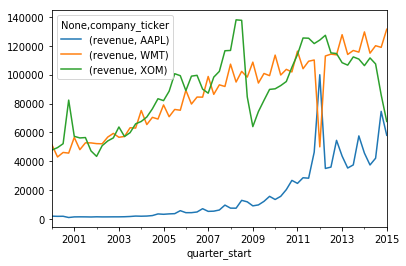

In [4]:
# Load the data
partial_tsdf, test_tsdf = load_dow_jones_dataset(test_size=1)

# Sort by index so that we can slice
partial_tsdf.sort_index(inplace=True)

# Take 3 grains from the test_tsdf for easy inspection
tsdf = partial_tsdf.loc[partial_tsdf.grain_index.isin(['AAPL', 'WMT', 'XOM']), ].copy()

# Add artificial outliers
tsdf.loc[pd.IndexSlice['2012-01-01', 'AAPL'], 'revenue'] = 100000
tsdf.loc[pd.IndexSlice['2012-01-01', 'WMT'], 'revenue'] = 50000

plot_by_grain(tsdf)


In [6]:
# TimeSeriesDataFrame info
print(tsdf.info())

# Find info about the shape of the TimeSeriesDataframe
print(tsdf.shape)

# Describe TimeSeriesDataframe
print(tsdf.describe())

# Index names
#print(tsdf.index.names)
print(tsdf.index.names)
# output_tsdf.loc["AAPL"].groupby("quarter_start").sum()
import pickle
pickle.dump(tsdf, file=open("tsdf.pkl", 'wb'))

<class 'ftk.time_series_data_frame.TimeSeriesDataFrame'>
MultiIndex: 183 entries, (2000-01-01 00:00:00, AAPL) to (2015-01-01 00:00:00, XOM)
Data columns (total 1 columns):
revenue    183 non-null float64
dtypes: float64(1)
memory usage: 7.7+ KB
None
(183, 1)
        revenue
count    183.00
mean   64186.78
std    41206.73
min     1007.00
25%    28420.50
50%    65443.00
75%    99905.50
max   138072.00
['quarter_start', 'company_ticker']


## Helper functions for outlier detection

## Detect outliers

By default, the `remove_outlier` function detects outliers and replace them with np.nan. Note that a spurious value was removed from XOM.

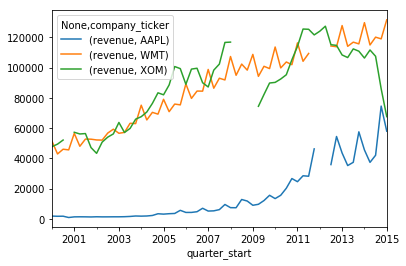

In [7]:
output_tsdf = remove_outlier(tsdf,  iqr_limit=1.5, residual_compute_method='stl')
plot_by_grain(output_tsdf)

Alternatively, you can replace the outliers at the lower end with the 25 percentile value, and outliers at the upper end with the 75 percentile value. Please see the docstring of the `remove_outliers` function for details.

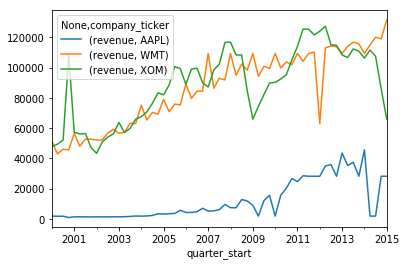

In [8]:
output_tsdf_2 = remove_outlier(tsdf, residual_compute_method='lowess', replace_with='iqr_bound')
plot_by_grain(output_tsdf_2)

You can also preserve the outlier values by setting `replace_with` to `None`. Then set `output_outlier_score` to `True` to get an `outlier_score` column in the output. 

In [9]:
output_tsdf_3 = remove_outlier(tsdf, replace_with=None, output_outlier_score=True)
output_tsdf_3.loc[output_tsdf_3['outlier_score'] >0, :]


revenue  outlier_score
quarter_start company_ticker                         
2000-10-01    XOM             82409.00           1.26
2008-04-01    XOM            138072.00           0.16
2008-07-01    XOM            137737.00           1.59
2008-10-01    XOM             84696.00           0.18
2009-01-01    XOM             64028.00           0.32
2011-10-01    WMT            110226.00           0.97
2012-01-01    AAPL           100000.00           5.62
              WMT             50000.00           7.18
2012-04-01    AAPL            35023.00           0.92
              WMT            113010.00           1.27

## Impute outliers
After outlier detection, if you chose to replace outliers with `nan` values, you can use the `impute_missing_value` method of `TimeSeriesDataFrame` to impute the new data frame with `nan` values.

In [10]:
output_tsdf = output_tsdf.impute_missing_value(input_column=output_tsdf.ts_value_colname, 
                                               option='interpolate', 
                                               method='linear',
                                               freq='QS')
plot_by_grain(output_tsdf)

AttributeError: 'TimeSeriesDataFrame' object has no attribute 'impute_missing_value'